In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-news/submit.csv
/kaggle/input/fake-news/train.csv
/kaggle/input/fake-news/test.csv


In [3]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, classification_report

import warnings
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv("/kaggle/input/fake-news/train.csv")
test= pd.read_csv('/kaggle/input/fake-news/test.csv')

In [5]:
data

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


### Data Cleaning and Preprocessing

In [6]:
#Handle missing data
data.fillna("", inplace=True)
test.fillna("", inplace=True)

In [7]:
# Convert text to lowercase
data['processed_text'] = data['text'].apply(lambda x: x.lower())
test['processed_text'] = test['text'].apply(lambda x: x.lower())

In [8]:
# Remove irrelevant characters using regular expressions
def remove_special_characters(text):
    pattern = r'[^a-zA-Z\s]'
    return re.sub(pattern, '', text)

data['processed_text'] = data['processed_text'].apply(remove_special_characters)
test['processed_text'] = test['processed_text'].apply(remove_special_characters)

In [9]:
nltk.download('punkt')
# Tokenization using NLTK's word_tokenize
data['processed_text'] = data['processed_text'].apply(word_tokenize)
test['processed_text'] = test['processed_text'].apply(word_tokenize)

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [10]:
data

,id,title,author,text,label,processed_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[house, dem, aide, we, didnt, even, see, comey..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"[ever, get, the, feeling, your, life, circles,..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"[why, the, truth, might, get, you, fired, octo..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"[videos, civilians, killed, in, single, us, ai..."
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"[print, an, iranian, woman, has, been, sentenc..."
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,"[rapper, t, i, unloaded, on, black, celebritie..."
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"[when, the, green, bay, packers, lost, to, the..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,"[the, macys, of, today, grew, from, the, union..."
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"[nato, russia, to, hold, parallel, exercises, ..."


In [11]:
nltk.download('stopwords')
# Remove stop words
stop_words = set(stopwords.words('english'))

data['processed_text'] = data['processed_text'].apply(lambda x: [word for word in x if word not in stop_words])
test['processed_text'] = test['processed_text'].apply(lambda x: [word for word in x if word not in stop_words])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [12]:
# Initialize PorterStemmer for stemming
stemmer = PorterStemmer()

# Apply stemming to the tokens
data['processed_text'] = data['processed_text'].apply(lambda x: [stemmer.stem(word) for word in x])
test['processed_text'] = test['processed_text'].apply(lambda x: [stemmer.stem(word) for word in x])

In [13]:
data

,id,title,author,text,label,processed_text
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,"[hous, dem, aid, didnt, even, see, comey, lett..."
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,"[ever, get, feel, life, circl, roundabout, rat..."
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"[truth, might, get, fire, octob, tension, inte..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,"[video, civilian, kill, singl, us, airstrik, i..."
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,"[print, iranian, woman, sentenc, six, year, pr..."
...,...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0,"[rapper, unload, black, celebr, met, donald, t..."
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0,"[green, bay, packer, lost, washington, redskin..."
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0,"[maci, today, grew, union, sever, great, name,..."
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1,"[nato, russia, hold, parallel, exercis, balkan..."


### Tokenization and Padding

In [14]:
# Tokenize the text and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['processed_text'])

train_sequences = tokenizer.texts_to_sequences(data['processed_text'])
test_sequences = tokenizer.texts_to_sequences(test['processed_text'])

In [15]:
data_nonE = data[data['processed_text'].apply(len) > 0]

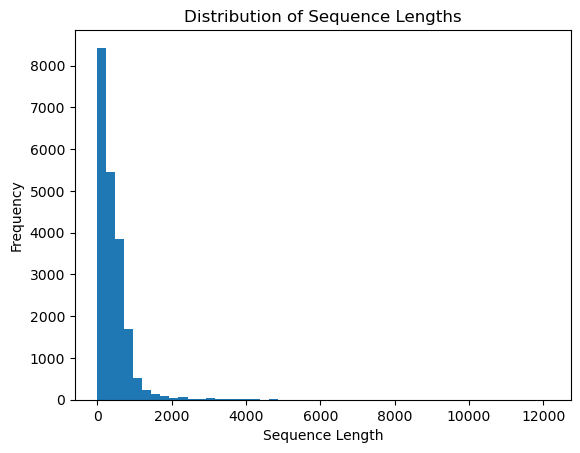

In [16]:
# Calculate sequence lengths
sequence_lengths = data_nonE['processed_text'].apply(len)
#sequence_lengths.append(test['processed_text'].apply(len))
# Analyze the distribution of sequence lengths
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [17]:
mean_length = sequence_lengths.mean()
median_length = sequence_lengths.median()
mode_length = sequence_lengths.mode().values[0]

print(f"Mean Length: {mean_length}")
print(f"Median Length: {median_length}")
print(f"Mode Length: {mode_length}")

Mean Length: 420.71478412559964
Median Length: 312.0
Mode Length: 6


In [18]:
# Pad sequences to the same length
max_seq_length = 500
data_padded = pad_sequences(train_sequences, maxlen=max_seq_length)
test_data_padded = pad_sequences(test_sequences, maxlen=max_seq_length)

In [19]:
X = data_padded
y = data['label']

X_test = test_data_padded

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)

### LSTM

In [20]:
# Build the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length))
model.add(LSTM(units=128))
model.add(Dense(units=64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
batch_size = 32
epochs = 10

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
520/520 [==============================] - 136s 247ms/step - loss: 0.2494 - accuracy: 0.8994 - val_loss: 0.1575 - val_accuracy: 0.9466
Epoch 2/10
520/520 [==============================] - 81s 155ms/step - loss: 0.0768 - accuracy: 0.9752 - val_loss: 0.1498 - val_accuracy: 0.9507
Epoch 3/10
520/520 [==============================] - 54s 103ms/step - loss: 0.0306 - accuracy: 0.9910 - val_loss: 0.1913 - val_accuracy: 0.9411
Epoch 4/10
520/520 [==============================] - 39s 75ms/step - loss: 0.0215 - accuracy: 0.9948 - val_loss: 0.2326 - val_accuracy: 0.9166
Epoch 5/10
520/520 [==============================] - 38s 73ms/step - loss: 0.0557 - accuracy: 0.9814 - val_loss: 0.2461 - val_accuracy: 0.9406


In [22]:
y_hat_LSTM = model.predict(test_data_padded)
y_hat_LSTM= (y_hat_LSTM > 0.5).astype(int).flatten()

163/163 [==============================] - 2s 10ms/step


In [23]:
test["label"]= y_hat_LSTM
submit_df = test[["id","label"]]
submit_df.to_csv("submit_LSTM.csv", index=False)

### Bidirectional LSTM

In [24]:
# Build the model with Bidirectional LSTM
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index)+1, output_dim=128, input_length=max_seq_length))
model.add(SpatialDropout1D(0.2))
model.add(Bidirectional(LSTM(256, dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

batch_size = 128
epochs = 6

model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/6
130/130 [==============================] - 54s 377ms/step - loss: 0.4035 - accuracy: 0.8178 - val_loss: 0.4078 - val_accuracy: 0.8082
Epoch 2/6
130/130 [==============================] - 43s 332ms/step - loss: 0.1450 - accuracy: 0.9461 - val_loss: 0.1680 - val_accuracy: 0.9442
Epoch 3/6
130/130 [==============================] - 40s 309ms/step - loss: 0.0556 - accuracy: 0.9827 - val_loss: 0.1852 - val_accuracy: 0.9363
Epoch 4/6
130/130 [==============================] - 41s 314ms/step - loss: 0.0224 - accuracy: 0.9941 - val_loss: 0.2186 - val_accuracy: 0.9433
Epoch 5/6
130/130 [==============================] - 38s 291ms/step - loss: 0.0103 - accuracy: 0.9972 - val_loss: 0.2326 - val_accuracy: 0.9445


In [26]:
y_hat_BiLSTM = model.predict(test_data_padded)
y_hat_BiLSTM= (y_hat_BiLSTM > 0.5).astype(int).flatten()

163/163 [==============================] - 4s 20ms/step


In [27]:
test["label"]= y_hat_BiLSTM
submit_df = test[["id","label"]]
submit_df.to_csv("submit_BiLSTM.csv", index=False)